## Simulate responses for arbitrary input (from the models trained on real data)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from PIL import Image

from neuraldistributions.models import transforms

device = "cuda"

In [2]:
def subtract_min(arr):
    return arr - arr.min()

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def imread(filename, grayscale=True, xres=None, yres=None):
    img = Image.open(filename)
    h, w, *_ = np.array(img).shape
    aspectratio = h / w

    xres = xres if xres is not None else w
    yres = yres if yres is not None else int(xres * aspectratio)
    
    image = np.array(img.resize((xres, yres), Image.ANTIALIAS))
    
    return rgb2gray(image)[None, None, :, :].astype(np.float32) if grayscale else image.transpose(2, 0, 1)[None, :, :, :].astype(np.float32)


### Load an arbitrary image

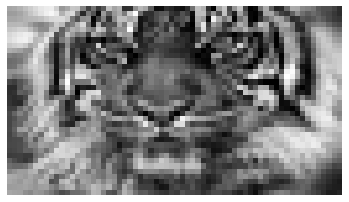

In [4]:
filename = "/project/notebooks/arbitrary_image.jpg"
target_image = imread(filename, xres=64, yres=36) / 255

plt.imshow(target_image[0, 0], cmap="gray")
plt.axis("off");

### Load a trained model

In [5]:
ziffa_scan2 = torch.load("/project/models/ziffa_scan2")

In [6]:
device = next(ziffa_scan2.parameters()).device

### Simulate responses

In [96]:
n_samples = 1000
n_neurons = ziffa_scan2.C.shape[1]
mu, q = ziffa_scan2(torch.from_numpy(target_image).to(device))

neuron_indices = [0, 1]
mu = mu.cpu().data.numpy()[0, neuron_indices]
q = q.cpu().data.numpy()[0, neuron_indices]
sigma = ziffa_scan2.sigma.cpu().data.numpy()[neuron_indices, :][:, neuron_indices]
zero_threshold = ziffa_scan2.zero_threshold.cpu().data.numpy().item()

In [97]:
samples = []
for _ in tqdm(range(n_samples)):
    xs = np.random.multivariate_normal(mu, sigma)
    xs = np.concatenate((xs, np.zeros(n_neurons - len(xs))))
    ys_g = ziffa_scan2.sample_transform.inv(torch.tensor([xs]).to(device))[0, neuron_indices].cpu().data.numpy()
    
    _samples = []
    for i, y_g in enumerate(ys_g):
        y_u = np.random.uniform(0, zero_threshold)

        assign_to_uniform = np.random.rand() < q[i]
        if assign_to_uniform:
            _samples.append(y_u)
        else:
            _samples.append(y_g)
            
    samples.append(_samples)
        
samples = np.array(samples)

100%|██████████| 1000/1000 [00:02<00:00, 385.78it/s]


### Learned vs simulated portion of zero responses

In [98]:
(samples[:, 0] < zero_threshold).sum()/n_samples, q[0]

(0.501, 0.4934838)

In [99]:
(samples[:, 1] < zero_threshold).sum()/n_samples, q[1]

(0.405, 0.40130273)

### Visualize the simulated responses

In [ ]:
y = torch.arange(0, 5, .01).to(device)[:, None] + 1.1e-7
out_model1 = ziffa_scan2.sample_transform(y)[0].cpu().data.numpy()

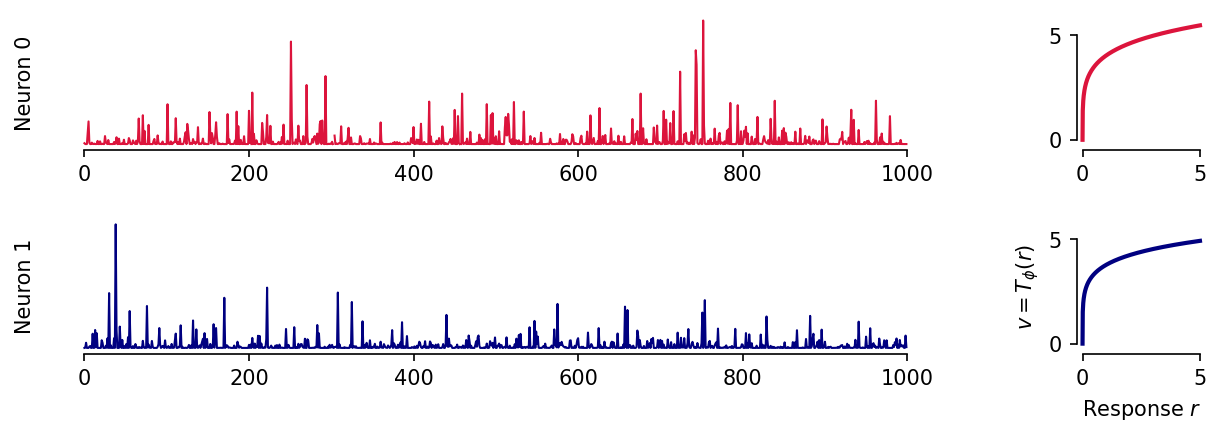

In [146]:
layout = """
    AAAAB
    CCCCD
    """
axes_dict = plt.figure(
    figsize=(10.0, 3.), dpi=150, constrained_layout=False
).subplot_mosaic(layout)
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.5
)
fig = plt.gcf()

ax = axes_dict["A"]
ax.plot(np.arange(n_samples), samples[:, 0], color="crimson", lw=1)
ax.set(yticks=[], ylabel=f"Neuron {neuron_indices[0]}")
sns.despine(trim=True, left=True, ax=ax)

ax = axes_dict["B"]
ax.plot(y.cpu().data.numpy(), subtract_min(out_model1[:, neuron_indices][:, 0]), lw=2, c='crimson')
ax.set(ylim=(-.5, 6), yticks=[0, 5])
sns.despine(trim=True, ax=ax)

ax = axes_dict["C"]
ax.plot(np.arange(n_samples), samples[:, 1]+7, color="navy", lw=1)
ax.set(yticks=[], ylabel=f"Neuron {neuron_indices[1]}")
sns.despine(trim=True, left=True, ax=ax)

ax = axes_dict["D"]
ax.plot(y.cpu().data.numpy(), subtract_min(out_model1[:, neuron_indices][:, 1]), lw=2, c='navy')
ax.set(ylim=(-.5, 6), yticks=[0, 5])
ax.set(xlabel=r"Response $r$", ylabel=r"$v = T_\phi(r)$")
sns.despine(trim=True, ax=ax)